# HMM Generative Modeling and Sampling

The goal of this workbook is to give an overview of the various generative modeling techniques and how they can be used with the discrete HMM training and infernece tools.

In [1]:
import pandas as pd
import numpy as np

import altair as alt
import hela.visualization.hmm as hmmplot
import matplotlib.pyplot as plt
%matplotlib inline

from hela import hmm
import hela.generation.hmm as gen
from scipy.special import logsumexp

from datetime import datetime
from dask.distributed import Client

TU_COLORS = [
    "#9b67ff", "#57b3c2", "#ffa040", "#ff6283", "#2ccc72", "#1270cb", "#bd043a",
    "#a1c54d", "#4c319e", "#c6c0fe", "#195036", "#f6a39f"
]

## Generate Data

### Classical HMM Generative Model

In this section we will create an instance of `DiscreteHMMGenerativeModel` which is a "classical" HMM in the sense that it's describing an HMM with a set number of discrete hidden states.  The generative model can be instantiated with flexible parameters, and any parameters not defined will be seeded randomly. 

We'll start by creating an instance of the generative model.

In [2]:
generative_model = gen.DiscreteHMMGenerativeModel(
                                     n_hidden_states =3,
                                     n_gaussian_features=2,
                                    n_categorical_features = 1,
                                     n_gmm_components = 1)

Now that we have the generative model, we can use this object to generate hidden states in a probabilistic way so that they have the underlying structure of the generative model.

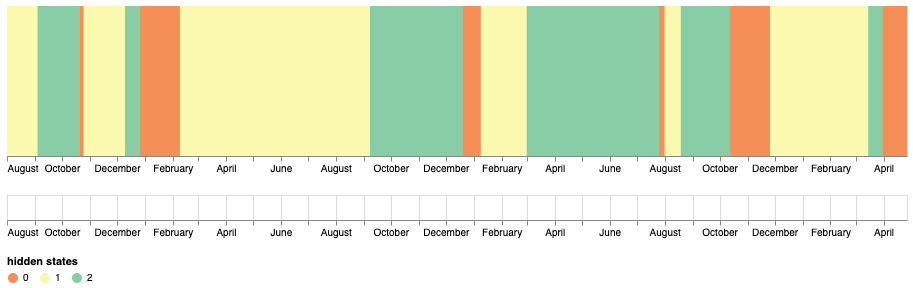

In [3]:
hidden_states = generative_model.generate_hidden_state_sequence(n_observations = 1000)
hmmplot.draw_states(hidden_states, hide_brush=False)

We've set up a series of hidden states, and now we can use this to generate synthetic data that is distributed according to `hidden_states` and the generative model parameters.

In [4]:
hmm_data = generative_model.generate_observations(hidden_states)
hmm_data.head()

,categorical_feature_0,gaussian_feature_0,gaussian_feature_1
2020-08-01,1,-2.595502,-4.454553
2020-08-02,1,-2.809800,-4.170959
2020-08-03,1,-2.672860,-5.443949
2020-08-04,1,-2.020112,-6.548659
2020-08-05,1,-3.022793,-5.116164


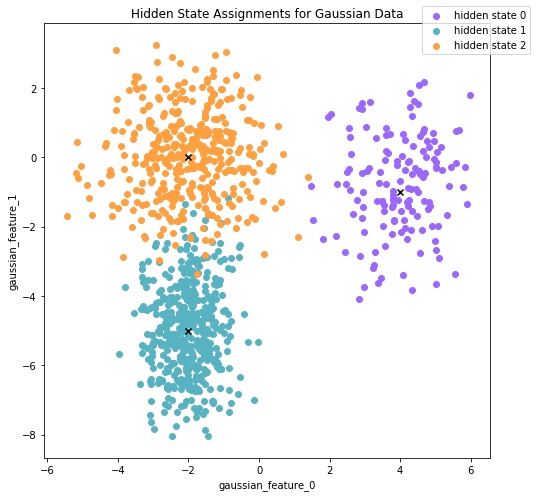

In [5]:
def plot_hidden_states(data, hidden_states,means, title):
    plt.figure(figsize = (8,8))
    for i in range(generative_model.n_hidden_states):
        idx = data[hidden_states == i].index
        plt.scatter(data.loc[idx,'gaussian_feature_0'], 
                    data.loc[idx,'gaussian_feature_1'], 
                    color = TU_COLORS[i],
                    label = "hidden state {}".format(i))
    for i in range(len(means)):
        plt.scatter(means[i][0][0], 
                    means[i][0][1], 
                    color = "black", 
                    marker = "x")

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.xlabel('gaussian_feature_0')
    plt.ylabel('gaussian_feature_1')
    plt.title(title)
    plt.show()
    
plot_hidden_states(hmm_data,hidden_states,generative_model.means,"Hidden State Assignments for Gaussian Data")

### Factored HMM Generative Model

In a similar way we can generate data with a factored HMM underlying structure.  _Note: This generative model is not yet set up to generate categorical data._

In [6]:
factored_generative_model = gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[2, 2, 2],
                                     n_gaussian_features = 2,
                                     n_categorical_features = 1)

From this model setup we can see that there are 3 underlying HMM system, each with 2 hidden states.  In a factored HMM hidden states are really hidden states vectors, so we can think of our hidden states in two ways.  

First, we will consider each system independently and view the hidden states as vectors.  In this way we can consider each of the three underlying HMM systems independently.

In [7]:
factored_hidden_states = factored_generative_model.generate_hidden_state_sequence(n_observations = 1000)

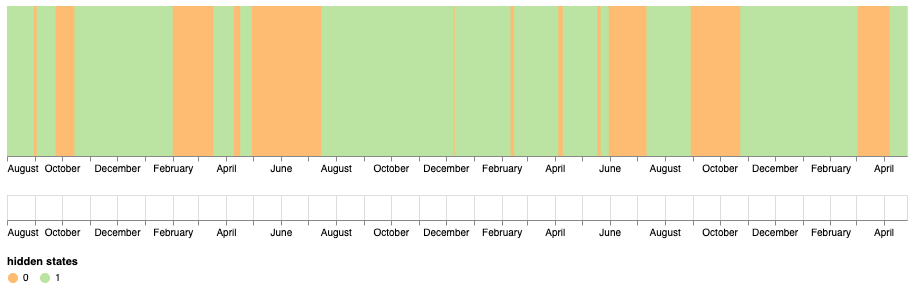

In [8]:
hmmplot.draw_states(factored_hidden_states[0], hide_brush=False)

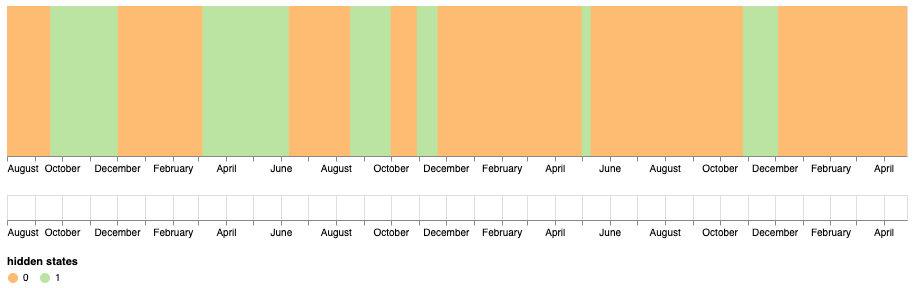

In [9]:
hmmplot.draw_states(factored_hidden_states[1], hide_brush=False)

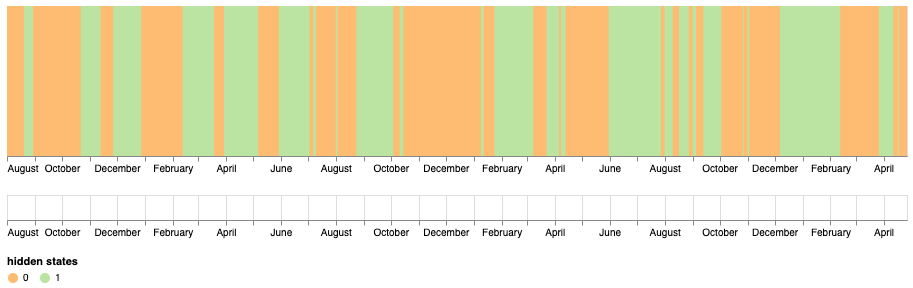

In [10]:
hmmplot.draw_states(factored_hidden_states[2], hide_brush=False)

Second, we will turned these factored hidden states into "flattened" hidden states, where we compress the vectors into 8 hidden states.  In this way we loose all of the factored HMM structure and just get an 8-state classical HMM.

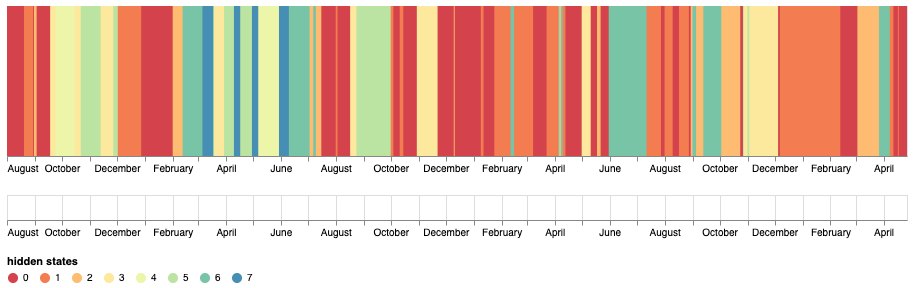

In [11]:
flattened_hidden_states = factored_generative_model.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

Just as in the classical case, we can use the hidden states to generate data with the correct underlying dynamics.  We will also look at the hidden state assignemnts for the Gaussian data, considering first the factored HMM and then the "flattened" classical HMM.

In [12]:
fhmm_data = factored_generative_model.generate_observations(factored_hidden_states)
fhmm_data[50:]

,categorical_feature_0,gaussian_feature_0,gaussian_feature_1
2020-09-20,1,-5.581957,1.175133
2020-09-21,1,-4.381055,0.380290
2020-09-22,1,-4.566026,0.323862
2020-09-23,1,-4.177434,0.147263
2020-09-24,1,-3.974852,1.026977
...,...,...,...
2023-04-23,0,-4.997513,0.775469
2023-04-24,0,-4.798528,0.801570
2023-04-25,0,-4.671221,1.433377
2023-04-26,1,-5.498732,0.342799


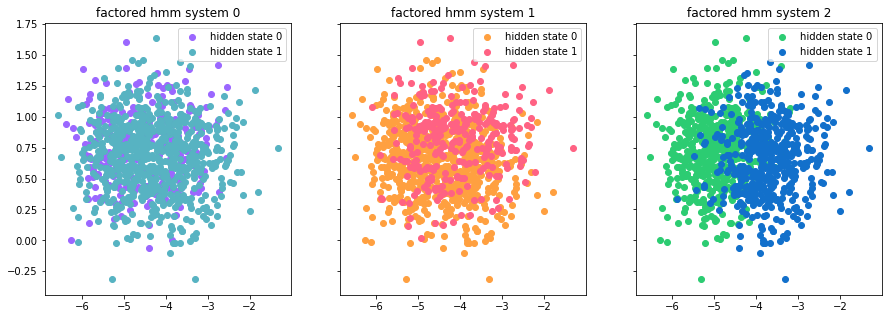

In [13]:
fig, axs= plt.subplots(1, 3, figsize = (15,5), sharey = "all")

for i in range(factored_hidden_states.shape[1]):
    df0 = fhmm_data[factored_hidden_states[i] == 0]
    df1 = fhmm_data[factored_hidden_states[i] == 1]

    axs[i].scatter(df0.loc[:,"gaussian_feature_0"], 
                   df0.loc[:,"gaussian_feature_1"], 
                   label = "hidden state 0",
                  color = TU_COLORS[2*i])
    axs[i].scatter(df1.loc[:,"gaussian_feature_0"], 
                   df1.loc[:,"gaussian_feature_1"], 
                   label = "hidden state 1",
                  color = TU_COLORS[(2*i) +1])
    axs[i].set_title("factored hmm system {}".format(i))
    axs[i].legend()

plt.show()

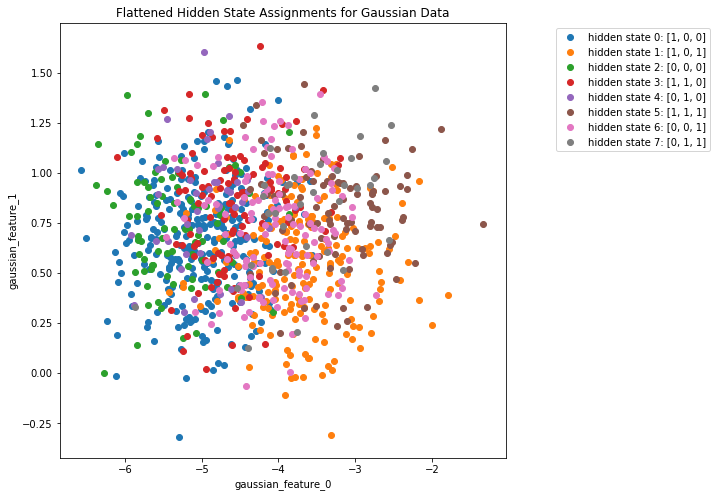

In [14]:
plt.figure(figsize = (8,8))
for i in flattened_hidden_states.unique():
    idx = fhmm_data[flattened_hidden_states == i].index
    vec = list(factored_hidden_states.loc[idx,:].iloc[0])
    plt.scatter(fhmm_data.loc[idx,'gaussian_feature_0'], fhmm_data.loc[idx,'gaussian_feature_1'], label = "hidden state {}: {}".format(i,vec))

plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.xlabel('gaussian_feature_0')
plt.ylabel('gaussian_feature_1')
plt.title('Flattened Hidden State Assignments for Gaussian Data')
plt.show()

## Classical HMM Training and Inference

### Training

Define a training spec seeded with values from the generative model (this isn't an exact copy of the hmm underlying the gerneative model, but it's meant to be "close enough").  To keep consistency with the HMM and factored HMM results, I'm going to ignore the categorical features for now.

In [15]:
training_spec = gen.data_to_discrete_hmm_training_spec(hidden_states=hidden_states, 
                                       n_hidden_states=generative_model.n_hidden_states, 
                                       data=hmm_data, 
                                       categorical_features = None,#list(generative_model.categorical_values.columns),
                                       gaussian_features=list(generative_model.gaussian_values.columns),
                                       n_gmm_components=1)

In [16]:
fhmm_training_spec = gen.data_to_fhmm_training_spec(hidden_states=factored_hidden_states, 
                                       ns_hidden_states=factored_generative_model.ns_hidden_states, 
                                       data=fhmm_data, 
                                       categorical_features = list(factored_generative_model.categorical_values.columns),
                                       gaussian_features=list(factored_generative_model.gaussian_values.columns))
fhmm_training_spec

{'hidden_state': {'type': 'finite', 'count': [2, 2, 2]},
 'n_systems': 3,
 'observations': [{'name': 'categorical_feature_0',
   'type': 'finite',
   'values': [0, 1]},
  {'name': 'gaussian_feature_0',
   'type': 'continuous',
   'dist': 'gaussian',
   'dims': 1},
  {'name': 'gaussian_feature_1',
   'type': 'continuous',
   'dist': 'gaussian',
   'dims': 1}],
 'model_parameter_constraints': {'transition_constraints': array([[[0.96      , 0.04      ],
          [0.01716738, 0.98283262]],
  
         [[0.99156118, 0.00843882],
          [0.02083333, 0.97916667]],
  
         [[0.95428571, 0.04571429],
          [0.05063291, 0.94936709]]]),
  'initial_state_constraints': array([[0., 1.],
         [1., 0.],
         [1., 0.]]),
  'emission_constraints': array([[0.73758865, 0.95734597, 1.        , 0.07017544, 0.84090909,
          0.12903226, 0.12030075, 0.89189189],
         [0.26241135, 0.04265403, 0.        , 0.92982456, 0.15909091,
          0.87096774, 0.87969925, 0.10810811]]),
  'gmm

In [22]:
def predict_hidden_state_log_probability_cat(data):
    log_probability = np.zeros((data.shape[0], self.model.ns_hidden_states, self.n_systems))
    if self.model.categorical_model is not None:
            finite_state_data = get_finite_observations_from_data_as_states(
                self.model, data)
            log_probability += np.array(
                self.model.categorical_model.log_probability(
                    finite_state_data))
def get_finite_observations_from_data_as_states(self.model, data):
    

In [18]:
model_config = hmm.DiscreteHMMConfiguration.from_spec(training_spec)
model_config

print(model_config.hidden_state_type)
print(model_config.model_parameter_constraints)
print(model_config.finite_features)
print(model_config.finite_values)
print(model_config.finite_values_dict)
print(model_config.finite_values_dict_inverse)
print(model_config.continuous_features)
print(model_config.continuous_values)

finite
{'transition_constraints': array([[0.96527778, 0.03472222, 0.        ],
       [0.        , 0.98723404, 0.01276596],
       [0.01558442, 0.        , 0.98441558]]), 'initial_state_constraints': array([0., 1., 0.]), 'emission_constraints': None, 'gmm_parameter_constraints': {'n_gmm_components': 1, 'means': array([[[ 3.97309233, -0.7946172 ]],

       [[-2.02528336, -4.9577674 ]],

       [[-2.04021639,  0.022164  ]]]), 'covariances': array([[[[0.92385879, 0.13354249],
         [0.13354249, 1.91724713]]],


       [[[0.41037378, 0.03457437],
         [0.03457437, 1.7316867 ]]],


       [[[1.38283332, 0.02801961],
         [0.02801961, 1.59289931]]]]), 'component_weights': array([[1.],
       [1.],
       [1.]])}}
[]
None
{}
{}
['gaussian_feature_0', 'gaussian_feature_1']
             gaussian_feature_0 gaussian_feature_1
dimension                     1                  1
distribution           gaussian           gaussian


In [19]:
fhmm_model_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)

# print(fhmm_model_config.hidden_state_type)
# print(fhmm_model_config.model_parameter_constraints)
print(fhmm_model_config.finite_features)
print(fhmm_model_config.finite_values)
# print(fhmm_model_config.finite_values_dict)
# print(fhmm_model_config.finite_values_dict_inverse)
# print(fhmm_model_config.continuous_features)
# print(fhmm_model_config.continuous_values)

['categorical_feature_0']
   categorical_feature_0
0                      0
1                      1


In [21]:
untrained_model = model_config.to_model()
fhmm_model_config.to_model()

NotImplementedError: FHMM not yet implemented

In [ ]:
# Load learning algorithm.
alg = hmm.LearningAlgorithm()

# Train model.
n_em_iterations = 10
model = alg.run(untrained_model, hmm_data, n_em_iterations)

# Print training results.
from scipy.special import logsumexp 

alphas = []
for s in alg.sufficient_statistics:
    s_inf = s.model.load_inference_interface()
    s_log_prob = s_inf.predict_hidden_state_log_probability(hmm_data)
    alpha = s_inf._compute_forward_probabilities(s_log_prob)
    alphas.append(logsumexp(alpha[-1]))
    
plt.figure(figsize = (15,5))
plt.scatter([x for x in range(len(alphas))],alphas, color = "#ffa040")

plt.title("Observed Data Log Likelihood")
plt.ylabel("Log likelihood")
plt.xlabel("Iteration Number")
plt.show()

### Inference

#### Hidden State Predictions with Viterbi Algorithm

The Viterbi algorithm is the most straightforward way to predict the most likely sequence of hidden states.  This should work very well (and relatively fast) for the data at hand, but the main drawback is that it becomes hard/impossible when we have a large number of hidden states.

In [ ]:
inf = model.load_inference_interface()
viterbi_predict = inf.predict_hidden_states_viterbi(hmm_data)
prop_correct = hidden_states[viterbi_predict == hidden_states].shape[0] / hidden_states.shape[0]
print("Viterbi proportion of correctly assigned hidden states: {}".format(prop_correct))

hmmplot.draw_states(viterbi_predict, hide_brush=False)

In [ ]:
plot_hidden_states(hmm_data,viterbi_predict,generative_model.means, "Hidden State Assignments with Viterbi Prediction")

#### Hidden State Predictions with Gibbs Sampling

Gibbs sampling will not be as accurate at Viterbi (and in this instance will take longer), but it's more scalable so should be helpful in the long run when we consider HMMs and flattened fHMMs that have a large number of hidden states.

In [ ]:
i = 100 #Ideally this should be very large.
gibbs_predict = inf.predict_hidden_states_gibbs(data = hmm_data,n_iterations = i)

prop_correct = hidden_states[gibbs_predict == hidden_states].shape[0] / hidden_states.shape[0]
print("Gibbs proportion of correctly assigned hidden states with {} iterations: {}".format(i,prop_correct))

hmmplot.draw_states(gibbs_predict, hide_brush=False)

To get slightly better accuracy we can also run multiple threads of locally distributed Gibbs sampling, gather the results, and take the mode.

In [ ]:
n_workers = 8
client = Client(processes=True, n_workers=n_workers, threads_per_worker=1)

In [ ]:
partitioned_data = [hmm_data for i in range(n_workers)]
inf = model.load_inference_interface()

In [ ]:
def gibbs_sample(data):
    
    return inf.predict_hidden_states_gibbs(data = hmm_data,n_iterations = 1000)

big_data = client.scatter(partitioned_data)
mapped = client.map(gibbs_sample, big_data)
result = client.gather(mapped)

dist_gibbs_predict = pd.concat(result, axis = 1).mode(axis = 1)[0]

prop_correct = hidden_states[dist_gibbs_predict == hidden_states].shape[0] / hidden_states.shape[0]
print("The proportion of Gibbs correctly assigned hidden states with {} iterations: {}".format(i,prop_correct))

hmmplot.draw_states(dist_gibbs_predict, hide_brush=False)

## Factored HMM Training and Inference

### Training

Define a training spec seeded with values from the flattened factored generative model.  At the moment we don't have any mature algorithms for sampling and inference for truly factored models, so the best we can do is work with the flattened model.  

In [ ]:
factored_hidden_states
fhmm_training_spec = gen.data_to_discrete_hmm_training_spec(hidden_states=flattened_hidden_states, 
                                       n_hidden_states=len(flattened_hidden_states.unique()), 
                                       data=fhmm_data, 
                                       categorical_features = None,#list(generative_model.categorical_values.columns),
                                       gaussian_features=list(factored_generative_model.gaussian_values.columns),
                                       n_gmm_components=1)

In [ ]:
fhmm_model_config = hmm.DiscreteHMMConfiguration.from_spec(fhmm_training_spec)
fhmm_model_config.model_type

In [ ]:
fhmm_untrained_model = fhmm_model_config.to_model()

In [ ]:
# Load learning algorithm.
fhmm_alg = hmm.LearningAlgorithm()

# Train model.
n_em_iterations = 10
fhmm_model = fhmm_alg.run(fhmm_untrained_model, fhmm_data, n_em_iterations)

# Print training results.
from scipy.special import logsumexp 

alphas = []
for s in fhmm_alg.sufficient_statistics:
    s_inf = s.model.load_inference_interface()
    s_log_prob = s_inf.predict_hidden_state_log_probability(fhmm_data)
    alpha = s_inf._compute_forward_probabilities(s_log_prob)
    alphas.append(logsumexp(alpha[-1]))
    
plt.figure(figsize = (15,5))
plt.scatter([x for x in range(len(alphas))],alphas, color = "#ffa040")

plt.title("Observed Data Log Likelihood")
plt.ylabel("Log likelihood")
plt.xlabel("Iteration Number")
plt.show()

### Inference

Again, the best we can do right now is deal with the flattened HMM and hope that we're able to detect most the underlying Markov structure.  We don't yet have any inference tools that are made to fit factored HMMs, a good next step would be to write an improved Gibbs sampler for factors HMMs [Factorial Hidden Markov Models](https://www.ee.columbia.edu/~sfchang/course/svia-F03/papers/factorial-HMM-97.pdf) by Ghahramani and Jordan in section 3.3. 

In [ ]:
inf = fhmm_model.load_inference_interface()
fhmm_viterbi_predict = inf.predict_hidden_states_viterbi(fhmm_data)
prop_correct = flattened_hidden_states[fhmm_viterbi_predict == flattened_hidden_states].shape[0] / flattened_hidden_states.shape[0]
print("Viterbi proportion of correctly assigned hidden states: {}".format(prop_correct))

hmmplot.draw_states(fhmm_viterbi_predict, hide_brush=False)

In [ ]:
plt.figure(figsize = (8,8))
for i in flattened_hidden_states.unique():
    idx = fhmm_data[fhmm_viterbi_predict == i].index
    vec = list(factored_hidden_states.loc[idx,:].iloc[0])
    plt.scatter(fhmm_data.loc[idx,'gaussian_feature_0'], fhmm_data.loc[idx,'gaussian_feature_1'], label = "hidden state {}: {}".format(i,vec))

plt.legend(bbox_to_anchor=(1.1, 1.0))
plt.xlabel('gaussian_feature_0')
plt.ylabel('gaussian_feature_1')
plt.title('Flattened Hidden State Assignments for Gaussian Data')
plt.show()

In [ ]:
i = 1000 #Ideally this should be very large.
fhmm_gibbs_predict = inf.predict_hidden_states_gibbs(data = fhmm_data,n_iterations = i)

prop_correct = flattened_hidden_states[fhmm_gibbs_predict == flattened_hidden_states].shape[0] / flattened_hidden_states.shape[0]
print("Gibbs proportion of correctly assigned hidden states with {} iterations: {}".format(i,prop_correct))

hmmplot.draw_states(gibbs_predict, hide_brush=False)